In [1]:
import os 
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn 
import torch.optim as optim 
from torch.autograd import Variable
from torch.utils import data 
from torchvision.datasets import ImageFolder 
from torchvision import transforms, datasets 
from torchvision.utils import make_grid

In [2]:
!wget https://www.dropbox.com/sh/isslk5zkp9ekqtc/AABTfbuLYRID6NhDvq1Vi7Hha?dl=0

--2021-02-28 08:04:10--  https://www.dropbox.com/sh/isslk5zkp9ekqtc/AABTfbuLYRID6NhDvq1Vi7Hha?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:601c:18::a27d:612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /sh/raw/isslk5zkp9ekqtc/AABTfbuLYRID6NhDvq1Vi7Hha [following]
--2021-02-28 08:04:10--  https://www.dropbox.com/sh/raw/isslk5zkp9ekqtc/AABTfbuLYRID6NhDvq1Vi7Hha
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc4905dafbbdd4dd41232b973b9f.dl.dropboxusercontent.com/zip_download_get/AtLsNA_cqZXCAfy8wb0OFwOo4wr4kcfM9WWVkY_C3-SAe_Q8Xvoo91PaQY1NYr9hnHaI7emeZLPmPlFkWp0Wqda_NFir06y4Wkx5li7orkgoCg [following]
--2021-02-28 08:04:10--  https://uc4905dafbbdd4dd41232b973b9f.dl.dropboxusercontent.com/zip_download_get/AtLsNA_cqZXCAfy8wb0OFwOo4wr4kcfM9WWVkY_C3-SAe_Q8Xvoo91PaQY1NYr9hnHaI7emeZLPmPlFkW

In [3]:
!mkdir pokemons
!unzip /content/AABTfbuLYRID6NhDvq1Vi7Hha?dl=0 -d /content/pokemons/

Archive:  /content/AABTfbuLYRID6NhDvq1Vi7Hha?dl=0
mapname:  conversion of  failed
 extracting: /content/pokemons/mgan_dataset.zip  

1 archive had fatal errors.


In [ ]:
#!unzip /content/pokemons/mgan_dataset.zip 

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:279: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


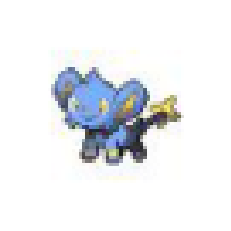

In [5]:
batch_size = 64
image_path = '/content/mgan_dataset/'

poke_transform = transforms.Compose([
                                     transforms.Scale(64),
                                     transforms.CenterCrop(64),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

poke_dataset = ImageFolder(image_path, poke_transform)
poke_loader = data.DataLoader(dataset = poke_dataset,
                              batch_size = batch_size,
                              shuffle = True,
                              num_workers = 1)

for img in poke_loader:
  imgone = img[0][0]
  imgone = (imgone * 0.5) + 0.5
  imgone = imgone.clamp(0.1)
  imgone = imgone.numpy()
  imgone = np.transpose(imgone, (1,2,0))
  plt.imshow(imgone)
  plt.axis('off')
  plt.show()
  break

In [6]:
n_epochs = 125
lr = 0.0002
label_smooth = 0.9
pokemon_models = '/content/mgan_dataset'
noise_dim = 100
d_filter_depth_in = 3

class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    self.main = nn.Sequential(
        nn.ConvTranspose2d(noise_dim, 512, kernel_size=4, stride=1, padding=0, bias=False),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.ConvTranspose2d(64,d_filter_depth_in, kernel_size=4, stride=2, padding=1, bias=False),
        nn.Tanh(),
    )

  def forward(self, inputs):
    output = self.main(inputs)
    return output

class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.main = nn.Sequential(
        nn.Conv2d(in_channels=d_filter_depth_in, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
        nn.LeakyReLU(0.2),
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(128), 
        nn.LeakyReLU(0.2),
        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(256), 
        nn.LeakyReLU(0.2),
        nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(512), 
        nn.LeakyReLU(0.2),
        nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, stride=1, padding=0, bias=False),
        nn.Sigmoid()
    )

  def forward(self, inputs):
    output = self.main(inputs)
    return output.view(-1,1).squeeze(1)

In [11]:
#Helper Functions
def weights_init(m):
  classname = m.__class__.__name__
  if classname.find('Conv2d') != -1:
    m.weight.data.normal_(0.0, 0.02)
  elif classname.find('BatchNorm2d') != -1:
    m.weight.data.normal_(1.0, 0.02)
    m.bias.data.fill_(0)

def to_variable(x):
  if torch.cuda.is_available():
    x = x.cuda()
    return Variable(x)

def denorm_poke(x):
  renorm = (x*0.5) + 0.5
  return renorm.clamp(0,1)

def plot_figure(fixed_noise):
  plt.figure()
  fixed_imgs = generator(fixed_noise)
  result = denorm_poke(fixed_imgs.cpu().data)
  result = make_grid(result)
  result = transforms.Compose([transforms.ToPILImage()])(result)
  plt.imshow(result)
  plt.axis('off')
  plt.show()

In [15]:
generator = Generator()
generator = generator.apply(weights_init)

discriminator = Discriminator()
discriminator.apply(weights_init)

loss_func = nn.BCELoss()
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.99))
g_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.99))

if torch.cuda.is_available():
  generator.cuda()
  discriminator.cuda()
  loss_func.cuda()

fixed_noise = to_variable(torch.randn(batch_size, noise_dim, 1, 1))

epoch 0
generator loss: 2.66, discriminator loss real: 0.68, discriminator loss fake: 0.38


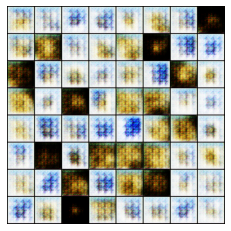

epoch 1
generator loss: 3.30, discriminator loss real: 0.58, discriminator loss fake: 0.27
epoch 2
generator loss: 3.14, discriminator loss real: 0.59, discriminator loss fake: 0.28
epoch 3
generator loss: 2.73, discriminator loss real: 0.63, discriminator loss fake: 0.33
epoch 4
generator loss: 2.72, discriminator loss real: 0.61, discriminator loss fake: 0.33
epoch 5
generator loss: 2.59, discriminator loss real: 0.62, discriminator loss fake: 0.34
epoch 6
generator loss: 2.65, discriminator loss real: 0.62, discriminator loss fake: 0.34
epoch 7
generator loss: 2.67, discriminator loss real: 0.61, discriminator loss fake: 0.32
epoch 8
generator loss: 2.86, discriminator loss real: 0.57, discriminator loss fake: 0.29
epoch 9
generator loss: 2.89, discriminator loss real: 0.59, discriminator loss fake: 0.29
epoch 10
generator loss: 2.87, discriminator loss real: 0.56, discriminator loss fake: 0.26


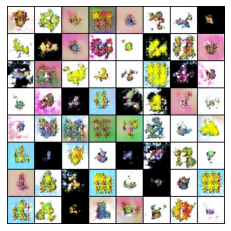

epoch 11
generator loss: 2.97, discriminator loss real: 0.56, discriminator loss fake: 0.26
epoch 12
generator loss: 3.00, discriminator loss real: 0.55, discriminator loss fake: 0.25
epoch 13
generator loss: 3.22, discriminator loss real: 0.54, discriminator loss fake: 0.21
epoch 14
generator loss: 3.33, discriminator loss real: 0.50, discriminator loss fake: 0.19
epoch 15
generator loss: 3.55, discriminator loss real: 0.51, discriminator loss fake: 0.19
epoch 16
generator loss: 3.57, discriminator loss real: 0.49, discriminator loss fake: 0.17
epoch 17
generator loss: 3.66, discriminator loss real: 0.48, discriminator loss fake: 0.16
epoch 18
generator loss: 3.67, discriminator loss real: 0.48, discriminator loss fake: 0.15
epoch 19
generator loss: 3.84, discriminator loss real: 0.46, discriminator loss fake: 0.14
epoch 20
generator loss: 3.92, discriminator loss real: 0.46, discriminator loss fake: 0.13


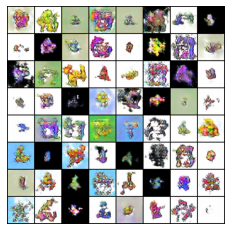

epoch 21
generator loss: 3.87, discriminator loss real: 0.47, discriminator loss fake: 0.13
epoch 22
generator loss: 3.83, discriminator loss real: 0.48, discriminator loss fake: 0.13
epoch 23
generator loss: 3.97, discriminator loss real: 0.45, discriminator loss fake: 0.10
epoch 24
generator loss: 3.93, discriminator loss real: 0.46, discriminator loss fake: 0.12
epoch 25
generator loss: 4.10, discriminator loss real: 0.46, discriminator loss fake: 0.12
epoch 26
generator loss: 3.99, discriminator loss real: 0.44, discriminator loss fake: 0.10
epoch 27
generator loss: 4.04, discriminator loss real: 0.46, discriminator loss fake: 0.12
epoch 28
generator loss: 3.94, discriminator loss real: 0.44, discriminator loss fake: 0.11
epoch 29
generator loss: 4.06, discriminator loss real: 0.45, discriminator loss fake: 0.10
epoch 30
generator loss: 4.10, discriminator loss real: 0.44, discriminator loss fake: 0.10


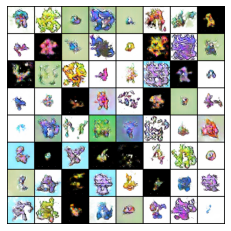

epoch 31
generator loss: 4.06, discriminator loss real: 0.45, discriminator loss fake: 0.10
epoch 32
generator loss: 4.17, discriminator loss real: 0.46, discriminator loss fake: 0.11
epoch 33
generator loss: 3.73, discriminator loss real: 0.47, discriminator loss fake: 0.13
epoch 34
generator loss: 4.12, discriminator loss real: 0.42, discriminator loss fake: 0.08
epoch 35
generator loss: 3.90, discriminator loss real: 0.47, discriminator loss fake: 0.11
epoch 36
generator loss: 4.00, discriminator loss real: 0.45, discriminator loss fake: 0.10
epoch 37
generator loss: 4.00, discriminator loss real: 0.47, discriminator loss fake: 0.12
epoch 38
generator loss: 4.06, discriminator loss real: 0.43, discriminator loss fake: 0.09
epoch 39
generator loss: 4.24, discriminator loss real: 0.41, discriminator loss fake: 0.07
epoch 40
generator loss: 4.29, discriminator loss real: 0.42, discriminator loss fake: 0.07


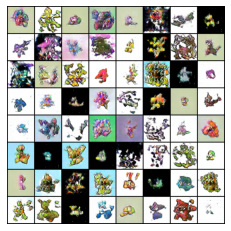

epoch 41
generator loss: 4.07, discriminator loss real: 0.45, discriminator loss fake: 0.10
epoch 42
generator loss: 4.42, discriminator loss real: 0.41, discriminator loss fake: 0.05
epoch 43
generator loss: 4.27, discriminator loss real: 0.42, discriminator loss fake: 0.06
epoch 44
generator loss: 4.22, discriminator loss real: 0.42, discriminator loss fake: 0.07
epoch 45
generator loss: 4.36, discriminator loss real: 0.42, discriminator loss fake: 0.07
epoch 46
generator loss: 4.28, discriminator loss real: 0.43, discriminator loss fake: 0.07
epoch 47
generator loss: 4.40, discriminator loss real: 0.42, discriminator loss fake: 0.07
epoch 48
generator loss: 4.33, discriminator loss real: 0.41, discriminator loss fake: 0.05
epoch 49
generator loss: 4.36, discriminator loss real: 0.42, discriminator loss fake: 0.07
epoch 50
generator loss: 4.35, discriminator loss real: 0.41, discriminator loss fake: 0.05


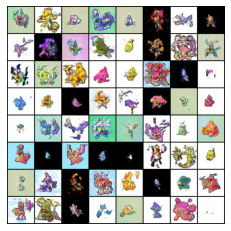

epoch 51
generator loss: 4.53, discriminator loss real: 0.43, discriminator loss fake: 0.07
epoch 52
generator loss: 4.50, discriminator loss real: 0.40, discriminator loss fake: 0.04
epoch 53
generator loss: 4.52, discriminator loss real: 0.41, discriminator loss fake: 0.05
epoch 54
generator loss: 4.60, discriminator loss real: 0.40, discriminator loss fake: 0.05
epoch 55
generator loss: 4.44, discriminator loss real: 0.41, discriminator loss fake: 0.05
epoch 56
generator loss: 4.37, discriminator loss real: 0.42, discriminator loss fake: 0.07
epoch 57
generator loss: 4.59, discriminator loss real: 0.40, discriminator loss fake: 0.04
epoch 58
generator loss: 4.50, discriminator loss real: 0.41, discriminator loss fake: 0.05
epoch 59
generator loss: 4.64, discriminator loss real: 0.41, discriminator loss fake: 0.05
epoch 60
generator loss: 4.67, discriminator loss real: 0.40, discriminator loss fake: 0.04


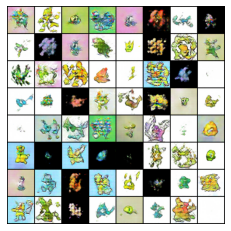

epoch 61
generator loss: 4.53, discriminator loss real: 0.40, discriminator loss fake: 0.05
epoch 62
generator loss: 4.73, discriminator loss real: 0.40, discriminator loss fake: 0.04
epoch 63
generator loss: 4.79, discriminator loss real: 0.39, discriminator loss fake: 0.04
epoch 64
generator loss: 4.59, discriminator loss real: 0.40, discriminator loss fake: 0.05
epoch 65
generator loss: 4.92, discriminator loss real: 0.38, discriminator loss fake: 0.03
epoch 66
generator loss: 4.53, discriminator loss real: 0.41, discriminator loss fake: 0.06
epoch 67
generator loss: 4.78, discriminator loss real: 0.39, discriminator loss fake: 0.04
epoch 68
generator loss: 4.70, discriminator loss real: 0.39, discriminator loss fake: 0.03
epoch 69
generator loss: 4.87, discriminator loss real: 0.39, discriminator loss fake: 0.03
epoch 70
generator loss: 4.78, discriminator loss real: 0.40, discriminator loss fake: 0.03


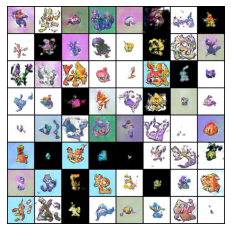

epoch 71
generator loss: 4.79, discriminator loss real: 0.38, discriminator loss fake: 0.03
epoch 72
generator loss: 4.90, discriminator loss real: 0.39, discriminator loss fake: 0.03
epoch 73
generator loss: 4.77, discriminator loss real: 0.43, discriminator loss fake: 0.07
epoch 74
generator loss: 4.52, discriminator loss real: 0.38, discriminator loss fake: 0.04
epoch 75
generator loss: 5.03, discriminator loss real: 0.38, discriminator loss fake: 0.02
epoch 76
generator loss: 4.82, discriminator loss real: 0.40, discriminator loss fake: 0.03
epoch 77
generator loss: 4.88, discriminator loss real: 0.39, discriminator loss fake: 0.04
epoch 78
generator loss: 4.90, discriminator loss real: 0.38, discriminator loss fake: 0.02
epoch 79
generator loss: 5.03, discriminator loss real: 0.38, discriminator loss fake: 0.03
epoch 80
generator loss: 4.83, discriminator loss real: 0.40, discriminator loss fake: 0.04


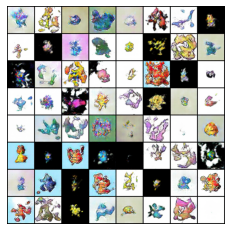

epoch 81
generator loss: 4.83, discriminator loss real: 0.41, discriminator loss fake: 0.04
epoch 82
generator loss: 4.74, discriminator loss real: 0.38, discriminator loss fake: 0.03
epoch 83
generator loss: 4.96, discriminator loss real: 0.38, discriminator loss fake: 0.02
epoch 84
generator loss: 5.04, discriminator loss real: 0.38, discriminator loss fake: 0.02
epoch 85
generator loss: 5.02, discriminator loss real: 0.38, discriminator loss fake: 0.02
epoch 86
generator loss: 5.00, discriminator loss real: 0.38, discriminator loss fake: 0.02
epoch 87
generator loss: 4.98, discriminator loss real: 0.38, discriminator loss fake: 0.02
epoch 88
generator loss: 4.82, discriminator loss real: 0.39, discriminator loss fake: 0.03
epoch 89
generator loss: 4.96, discriminator loss real: 0.38, discriminator loss fake: 0.02
epoch 90
generator loss: 5.19, discriminator loss real: 0.37, discriminator loss fake: 0.02


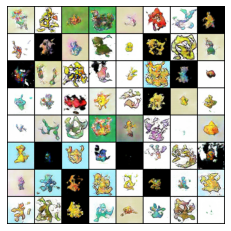

epoch 91
generator loss: 5.09, discriminator loss real: 0.38, discriminator loss fake: 0.02
epoch 92
generator loss: 4.95, discriminator loss real: 0.38, discriminator loss fake: 0.03
epoch 93
generator loss: 5.08, discriminator loss real: 0.37, discriminator loss fake: 0.02
epoch 94
generator loss: 5.07, discriminator loss real: 0.38, discriminator loss fake: 0.02
epoch 95
generator loss: 5.11, discriminator loss real: 0.38, discriminator loss fake: 0.02
epoch 96
generator loss: 5.03, discriminator loss real: 0.38, discriminator loss fake: 0.02
epoch 97
generator loss: 5.08, discriminator loss real: 0.38, discriminator loss fake: 0.02
epoch 98
generator loss: 5.17, discriminator loss real: 0.37, discriminator loss fake: 0.02
epoch 99
generator loss: 5.21, discriminator loss real: 0.37, discriminator loss fake: 0.02
epoch 100
generator loss: 5.13, discriminator loss real: 0.37, discriminator loss fake: 0.02


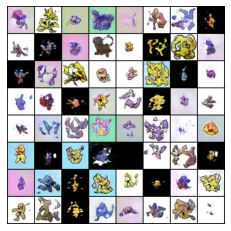

epoch 101
generator loss: 5.24, discriminator loss real: 0.37, discriminator loss fake: 0.02
epoch 102
generator loss: 5.22, discriminator loss real: 0.38, discriminator loss fake: 0.02
epoch 103
generator loss: 5.21, discriminator loss real: 0.36, discriminator loss fake: 0.01
epoch 104
generator loss: 5.10, discriminator loss real: 0.37, discriminator loss fake: 0.02
epoch 105
generator loss: 5.28, discriminator loss real: 0.37, discriminator loss fake: 0.01
epoch 106
generator loss: 5.20, discriminator loss real: 0.37, discriminator loss fake: 0.02
epoch 107
generator loss: 5.27, discriminator loss real: 0.37, discriminator loss fake: 0.02
epoch 108
generator loss: 5.09, discriminator loss real: 0.38, discriminator loss fake: 0.03
epoch 109
generator loss: 5.53, discriminator loss real: 0.35, discriminator loss fake: 0.01
epoch 110
generator loss: 5.34, discriminator loss real: 0.37, discriminator loss fake: 0.02


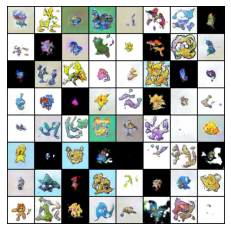

epoch 111
generator loss: 5.28, discriminator loss real: 0.37, discriminator loss fake: 0.02
epoch 112
generator loss: 5.24, discriminator loss real: 0.38, discriminator loss fake: 0.02
epoch 113
generator loss: 5.23, discriminator loss real: 0.36, discriminator loss fake: 0.01
epoch 114
generator loss: 5.31, discriminator loss real: 0.37, discriminator loss fake: 0.02
epoch 115
generator loss: 5.35, discriminator loss real: 0.37, discriminator loss fake: 0.01
epoch 116
generator loss: 5.31, discriminator loss real: 0.36, discriminator loss fake: 0.01
epoch 117
generator loss: 5.34, discriminator loss real: 0.37, discriminator loss fake: 0.02
epoch 118
generator loss: 5.28, discriminator loss real: 0.37, discriminator loss fake: 0.02
epoch 119
generator loss: 5.17, discriminator loss real: 0.37, discriminator loss fake: 0.02
epoch 120
generator loss: 5.45, discriminator loss real: 0.37, discriminator loss fake: 0.01


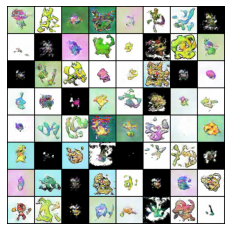

epoch 121
generator loss: 5.32, discriminator loss real: 0.36, discriminator loss fake: 0.02
epoch 122
generator loss: 5.37, discriminator loss real: 0.36, discriminator loss fake: 0.01
epoch 123
generator loss: 5.38, discriminator loss real: 0.36, discriminator loss fake: 0.01
epoch 124
generator loss: 5.28, discriminator loss real: 0.37, discriminator loss fake: 0.02


In [17]:
generator_losses, discriminator_losses = [], []

for epoch in range(n_epochs):
  gen_loss_epoch = 0
  dis_loss_epoch_fake = 0
  dis_loss_epoch_real = 0
  batches_processed = 0
  for i, image_batch in enumerate(poke_loader):
    batches_processed += 1
    image_batch = image_batch[0]
    batch_size = image_batch.shape[0]
    discriminator.zero_grad()

    real_images = to_variable(image_batch)
    real_outputs = discriminator(real_images)
    real_loss = loss_func(real_outputs, to_variable(torch.ones(real_outputs.data.shape))*label_smooth)
    real_loss.backward()
    dis_loss_epoch_real += torch.mean(real_loss.data)

    noise = to_variable(torch.randn(batch_size, noise_dim, 1, 1))
    fake_images = generator(noise)
    fake_outputs = discriminator(fake_images)
    fake_loss = loss_func(fake_outputs, to_variable(torch.zeros(fake_outputs.data.shape)))
    fake_loss.backward()
    dis_loss_epoch_fake += torch.mean(fake_loss.data)

    d_optimizer.step()
    generator.zero_grad()

    noise = to_variable(torch.randn(batch_size, noise_dim, 1, 1))
    fake_images = generator(noise)
    dis_outputs = discriminator(fake_images)
    gen_loss = loss_func(dis_outputs, to_variable(torch.ones(dis_outputs.data.shape)))
    gen_loss.backward()
    gen_loss_epoch += torch.mean(gen_loss.data)
    g_optimizer.step()

  discriminator_losses.append([dis_loss_epoch_real/batches_processed, dis_loss_epoch_fake/batches_processed])
  generator_losses.append(gen_loss_epoch/batches_processed)

  print('epoch {}'.format(epoch))
  print('generator loss: {:0.2f}, discriminator loss real: {:0.2f}, discriminator loss fake: {:0.2f}'.format(generator_losses[-1], discriminator_losses[-1][0], discriminator_losses[-1][1]))
  if epoch%10 == 0:
    plot_figure(fixed_noise)
  
  torch.save(generator.state_dict(), os.path.join(pokemon_models, 'generator_ep_%d' % epoch))
  torch.save(discriminator.state_dict(), os.path.join(pokemon_models, 'discriminator_ep_%d' % epoch))


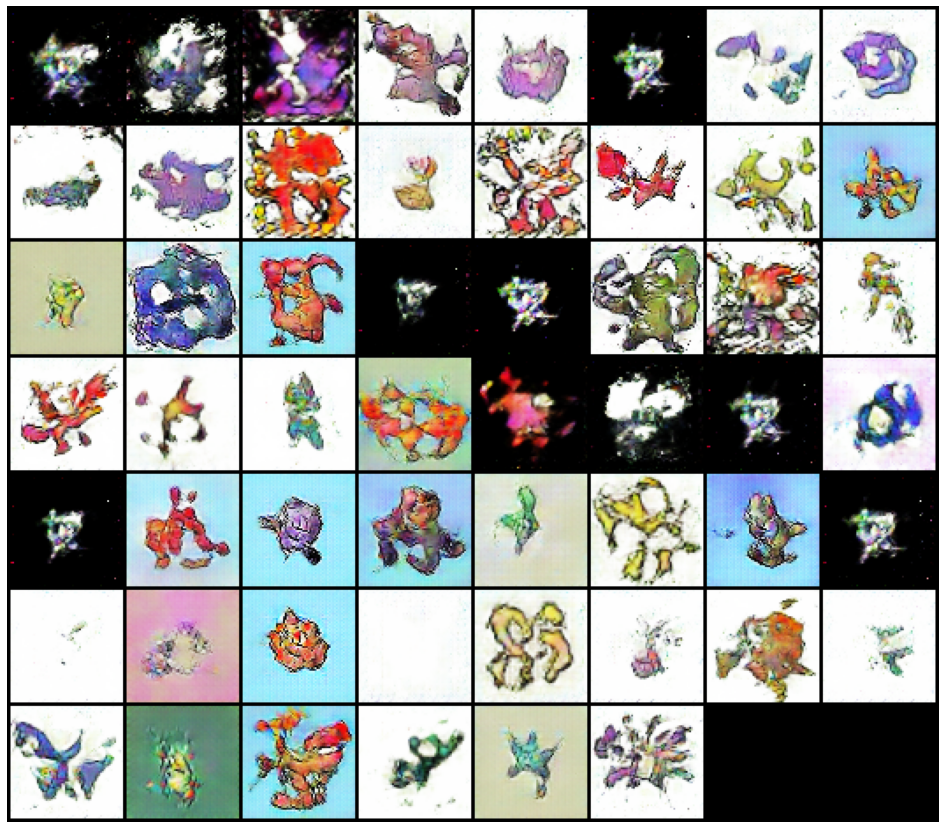

In [24]:
noise = to_variable(torch.randn(batch_size, noise_dim, 1, 1))

model_path = '/content/mgan_dataset/generator_ep_124'
generator_final = Generator()
generator_final.load_state_dict(torch.load(model_path))
generator_final.cuda()

fixed_imgs = generator_final(noise)
result = denorm_poke(fixed_imgs.cpu().data)
result = make_grid(result)
result = transforms.Compose([transforms.ToPILImage()])(result)

plt.figure(figsize = (20,15))
plt.imshow(result)
plt.axis('off')
plt.show()